# U-Net


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import sys
import os
from optparse import OptionParser
import numpy as np
from torch import optim
from PIL import Image
import progressbar
from torch.autograd import Function, Variable
import matplotlib.pyplot as plt
import matplotlib
from torchvision import transforms
from glob import glob
from skimage import io
from sklearn.feature_extraction.image import extract_patches_2d,reconstruct_from_patches_2d
import pickle
from torch.utils.data import Dataset
%matplotlib inline
import cv2

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [3]:
progress = progressbar.ProgressBar(widgets=[progressbar.Bar('*', '[', ']'), progressbar.Percentage(), ' '])

In [4]:
# DEFINE SINGLE_CONV CLASS
class single_conv(nn.Module):
    '''(conv => BN => ReLU) '''
    def __init__(self, in_ch, out_ch):
        super(single_conv, self).__init__()
        # Define the layers here
        # Note: for conv, use a padding of (1,1) so that size is maintained
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3,stride=1,padding=1)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        
        
    def forward(self, x):
        # define forward operation using the layers we have defined
        x = self.relu(self.bn(self.conv(x)))
        return x

# DEFINE DOWN CLASS
class down(nn.Module):
    def __init__(self):
        super(down, self).__init__()
        self.down = nn.MaxPool2d((2, 2)) # use nn.MaxPool2d( )
        
    def forward(self, x):
        x = self.down(x)
        
        return x


# DEFINE UP CLASS
# Note that this class will not only upsample x1, but also concatenate up-sampled x1 with x2 to generate the final output

class up(nn.Module):
    def __init__(self):
        super(up, self).__init__()       
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')  # use nn.Upsample() with mode bilinear

    def forward(self, x1, x2): # Takes in smaller x1 and larger x2
        # First we upsample x1 to be same size as x2
        x1 = self.up(x1)
        
        # This part is tricky so we've completed this
        # Notice that x2 and x1 may not have the same spatial size. 
        # This is because when you downsample old_x2(say 25 by 25), you will get x1(12 by 12)   
        # Then you perform upsample to x1, you will get new_x1(24 by 24)
        # You should pad a new row and column so that new_x1 and x2 have the same size.
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # Now we concatenat x2 and x1 along channel dimension: torch.cat()
        # Note pytorch tensor shape correspond to: (batchsize, channel, x_dim, y_dim)
        x = torch.cat((x1,x2), dim=1)
        
        return x


# DEFINE OUTCONV CLASS
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        # 1 conv layer
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1,stride=1,padding=0)

    def forward(self, x):
        x = self.conv(x)
        
        return x


In [5]:
################################################ [TODO] ###################################################
# Build your network with predefined classes: single_conv, up, down, outconv
# The number of input and output channels should follow the U-Net Structure shown above.
import torch.nn.functional as F
class UNet(nn.Module):
    def __init__(self, n_channels_in, n_channels_out):
        super(UNet, self).__init__()
        ## Define the necessary layers using the classes defined above
        self.conv1=single_conv(n_channels_in,16)
        self.down=down()
        self.up=up()
        self.conv2=single_conv(16,32)
        self.conv3=single_conv(32,32)
        self.conv4=single_conv(64,16)
        self.conv5=single_conv(32,16)
        self.outconv=outconv(16,n_channels_out)


    def forward(self, x):
        # Define forward pass
        x0=self.conv1(x)
        x1=self.down(x0)
        x1=self.conv2(x1)
        x2=self.down(x1)
        x2=self.conv3(x2)
        x3=self.up(x2,x1)
        x3=self.conv4(x3)
        x=self.up(x3,x0)
        x=self.conv5(x)
        x=self.outconv(x)
        
        return x
    

In [6]:
#### define transform classes for  data augmentation
class Flip(object):
    """
    Flip the image left or right for data augmentation, but prefer original image.
    """
    def __init__(self,ori_probability=0.60):
        self.ori_probability = ori_probability
 
    def __call__(self, sample):
        if random.uniform(0,1) < self.ori_probability:
            return sample
        else:
            img, label = sample['img'], sample['label']
            img_flip = img[:,:,::-1]
            label_flip = label[:,::-1]
            
            return {'img': img_flip, 'label': label_flip}
        
class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """
    def __init__(self):
        pass

    def __call__(self, sample):
        image, label = sample['img'], sample['label']

        return {'img': torch.from_numpy(image.copy()).type(torch.FloatTensor),
                'label': torch.from_numpy(label.copy()).type(torch.FloatTensor)}

In [7]:
train_img_masks_save_path = 'Pickles/train_img_masks.pickle'
if os.path.exists(train_img_masks_save_path):
    with open(train_img_masks_save_path,'rb') as f:
        train_img_masks = pickle.load(f)
    f.close()
else:
    print('Error! Training Set Pickle not found!')

val_img_masks_save_path = 'Pickles/val_img_masks.pickle'
if os.path.exists(val_img_masks_save_path):
    with open(val_img_masks_save_path,'rb') as f:
        val_img_masks = pickle.load(f)
    f.close()
else:
    print('Error! Validation Set Pickle not found!')

In [8]:
# the dataset class
class CustomDataset(Dataset):
    def __init__(self, image_masks, transforms=None): 

        self.image_masks = image_masks
        self.transforms = transforms
    
    def __len__(self):  # return count of sample we have

        return len(self.image_masks)
    
    def __getitem__(self, index):

        image = np.array(self.image_masks[index][0]) # Channel,H, W
        mask = self.image_masks[index][1]
        
        sample = {'img': image, 'label': mask}
        
        if transforms:
            sample = self.transforms(sample)
            
        return sample

train_dataset = CustomDataset(train_img_masks, transforms=transforms.Compose([Flip(),ToTensor()]))
val_dataset = CustomDataset(val_img_masks, transforms=transforms.Compose([Flip(),ToTensor()]))

In [9]:
# Create Model object from the class defined above. Input channels = 4, output channels = 5
net = UNet(4,5).to(device,dtype=torch.float32)
net.to(device) 
# if using GPU
# If continuing from previously saved model, use 
# net.load_state_dict(torch.load('PATH TO SAVED MODEL FILE'))
print(net)

# This shows the number of parameters in the network
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', n_params)

UNet(
  (conv1): single_conv(
    (conv): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (down): down(
    (down): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (up): up(
    (up): Upsample(scale_factor=2.0, mode=bilinear)
  )
  (conv2): single_conv(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv3): single_conv(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv4): single_conv(
    (conv): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True,

In [15]:
# Specify number of epochs, image scale factor, batch size and learning rate
epochs =  100        # e.g. 10, or more until CE converge
batch_size = 100    # e.g. 16
lr =   0.001          # e.g. 0.01
N_train = len(train_img_masks)
if not os.path.exists('Model_1'):
    os.mkdir('Model_1')
model_save_path = 'Model_1/'  # directory to same the model after each epoch. 

optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9,weight_decay=0.0005)
#suggested parameter settings: momentum=0.9, weight_decay=0.0005

# The loss function we use is Cross Entropy
criterion = nn.CrossEntropyLoss()

# Start training  #This part takes very long time to run if using CPU
for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    net.train()
    # Reload images and masks for training and validation and perform random shuffling at the begining of each epoch
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    epoch_loss = 0
    count = 0
    progress.currval = 0
    progress.max_value=len(train_loader)-1
    progress.start()
    for i, b in enumerate(train_loader):
        
        imgs = b['img'].to(device,dtype=torch.float32)
        true_masks = b['label'].to(device,dtype=torch.long)        
        masks_pred = net(imgs)
        # Calculate the loss by comparing the predicted masks vector and true masks vector
        # And sum the losses together 
        loss = criterion(masks_pred,true_masks.long())
        epoch_loss += loss
        if count % 20 == 0:  #Print status every 20 batch
            print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item())) 
        count = count + 1
        progress.update(i)
        # It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch finished ! Loss: {}'.format(epoch_loss / i))
    net.eval()
    val_cross=0.0
    val_tot=1
    with torch.no_grad():
        progress.currval = 0
        progress.max_value=len(val_loader)-1
        progress.start()
        for i, b in enumerate(val_loader):
            vimgs = b['img'].to(device,dtype=torch.float32)
            vtrue_masks = b['label'].to(device,dtype=torch.long)
            vmasks_pred = net(vimgs)
            vloss=criterion(vmasks_pred,vtrue_masks.long())
            val_cross += vloss
            val_tot=i+1
            progress.update(i)
    print('Validation Cross-Entropy Coeff: {}'.format(val_cross/i))
    
    # Save the model after each epoch
    if os.path.isdir(model_save_path):
        torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(model_save_path, exist_ok=True)
        torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved !'.format(epoch + 1))

    

[                                                                        ]N/A% 

Starting epoch 1/100.


[***                                                                     ]  5% 

0.0000 --- loss: 0.459090


[*************************************************                       ] 69% 

0.5000 --- loss: 0.460755


Epoch finished ! Loss: 0.4633990228176117
Validation Cross-Entropy Coeff: 0.5033482313156128
Checkpoint 1 saved !
Starting epoch 2/100.
0.0000 --- loss: 0.415680


[*******************************************************                 ] 76% 

0.5000 --- loss: 0.444531


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4558241069316864
Validation Cross-Entropy Coeff: 0.5021816492080688
Checkpoint 2 saved !
Starting epoch 3/100.
0.0000 --- loss: 0.458310


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.403603


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.45505475997924805
Validation Cross-Entropy Coeff: 0.49897778034210205
Checkpoint 3 saved !
Starting epoch 4/100.
0.0000 --- loss: 0.460782


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.454941


[*****                                                                   ]  7% 

Epoch finished ! Loss: 0.4537065029144287
Validation Cross-Entropy Coeff: 0.49892058968544006
Checkpoint 4 saved !
Starting epoch 5/100.
0.0000 --- loss: 0.405305


[*************************************************                       ] 69% 

0.5000 --- loss: 0.420077


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4523654282093048
Validation Cross-Entropy Coeff: 0.5007813572883606
Checkpoint 5 saved !
Starting epoch 6/100.
0.0000 --- loss: 0.430151


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.441298


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4549081325531006
Validation Cross-Entropy Coeff: 0.5015352368354797
Checkpoint 6 saved !
Starting epoch 7/100.
0.0000 --- loss: 0.448661


[************************************************                        ] 66% 

0.5000 --- loss: 0.436623


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.45557722449302673
Validation Cross-Entropy Coeff: 0.4983021914958954
Checkpoint 7 saved !
Starting epoch 8/100.
0.0000 --- loss: 0.492507


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.450907


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.45422354340553284
Validation Cross-Entropy Coeff: 0.5029325485229492
Checkpoint 8 saved !
Starting epoch 9/100.
0.0000 --- loss: 0.447110


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.430322


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4534056782722473
Validation Cross-Entropy Coeff: 0.502308189868927
Checkpoint 9 saved !
Starting epoch 10/100.
0.0000 --- loss: 0.384112


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.420287


[*****                                                                   ]  7% 

Epoch finished ! Loss: 0.45448777079582214
Validation Cross-Entropy Coeff: 0.502302348613739
Checkpoint 10 saved !
Starting epoch 11/100.
0.0000 --- loss: 0.506127


[*************************************************                       ] 69% 

0.5000 --- loss: 0.472988


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4527963697910309
Validation Cross-Entropy Coeff: 0.5047417283058167
Checkpoint 11 saved !
Starting epoch 12/100.
0.0000 --- loss: 0.425731


[***************************************************                     ] 71% 

0.5000 --- loss: 0.464070


[*****                                                                   ]  7% 

Epoch finished ! Loss: 0.4524213969707489
Validation Cross-Entropy Coeff: 0.5002870559692383
Checkpoint 12 saved !
Starting epoch 13/100.
0.0000 --- loss: 0.437667


[*************************************************                       ] 69% 

0.5000 --- loss: 0.452554


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.45333272218704224
Validation Cross-Entropy Coeff: 0.5020438432693481
Checkpoint 13 saved !
Starting epoch 14/100.
0.0000 --- loss: 0.405724


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.441088


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.4527733325958252
Validation Cross-Entropy Coeff: 0.5031428933143616
Checkpoint 14 saved !
Starting epoch 15/100.
0.0000 --- loss: 0.437965


[************************************************                        ] 66% 

0.5000 --- loss: 0.426153


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.45387306809425354
Validation Cross-Entropy Coeff: 0.5001728534698486
Checkpoint 15 saved !
Starting epoch 16/100.
0.0000 --- loss: 0.414938


[************************************************                        ] 66% 

0.5000 --- loss: 0.435101


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.452790766954422
Validation Cross-Entropy Coeff: 0.49834340810775757
Checkpoint 16 saved !
Starting epoch 17/100.
0.0000 --- loss: 0.451044


0.5000 --- loss: 0.418941


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4505104124546051
Validation Cross-Entropy Coeff: 0.5023953318595886
Checkpoint 17 saved !
Starting epoch 18/100.
0.0000 --- loss: 0.512557


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.441564


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4527892768383026
Validation Cross-Entropy Coeff: 0.5039728879928589
Checkpoint 18 saved !
Starting epoch 19/100.
0.0000 --- loss: 0.420539


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.408140


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.4525437653064728
Validation Cross-Entropy Coeff: 0.4988517165184021
Checkpoint 19 saved !
Starting epoch 20/100.
0.0000 --- loss: 0.480171


[*************************************************                       ] 69% 

0.5000 --- loss: 0.432336


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.458676278591156
Validation Cross-Entropy Coeff: 0.49992048740386963
Checkpoint 20 saved !
Starting epoch 21/100.
0.0000 --- loss: 0.444231


[************************************************                        ] 66% 

0.5000 --- loss: 0.462671


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.45430105924606323
Validation Cross-Entropy Coeff: 0.49864229559898376
Checkpoint 21 saved !
Starting epoch 22/100.
0.0000 --- loss: 0.440610


[*************************************************                       ] 69% 

0.5000 --- loss: 0.425735


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.45520737767219543
Validation Cross-Entropy Coeff: 0.5001285672187805
Checkpoint 22 saved !
Starting epoch 23/100.
0.0000 --- loss: 0.449870


0.5000 --- loss: 0.444169


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.45291420817375183
Validation Cross-Entropy Coeff: 0.5006224513053894
Checkpoint 23 saved !
Starting epoch 24/100.
0.0000 --- loss: 0.462689


[************************************************                        ] 66% 

0.5000 --- loss: 0.454260


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.453990638256073
Validation Cross-Entropy Coeff: 0.5009234547615051
Checkpoint 24 saved !
Starting epoch 25/100.
0.0000 --- loss: 0.450369


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.462906


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4526287615299225
Validation Cross-Entropy Coeff: 0.5054769515991211
Checkpoint 25 saved !
Starting epoch 26/100.
0.0000 --- loss: 0.417970


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.401316


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.45222631096839905
Validation Cross-Entropy Coeff: 0.5030394792556763
Checkpoint 26 saved !
Starting epoch 27/100.
0.0000 --- loss: 0.419327


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.448107


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.45030295848846436
Validation Cross-Entropy Coeff: 0.5006647706031799
Checkpoint 27 saved !
Starting epoch 28/100.
0.0000 --- loss: 0.439507


0.5000 --- loss: 0.399723


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4524668753147125
Validation Cross-Entropy Coeff: 0.4988115727901459
Checkpoint 28 saved !
Starting epoch 29/100.
0.0000 --- loss: 0.444075


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.415390


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.45326051115989685
Validation Cross-Entropy Coeff: 0.49970823526382446
Checkpoint 29 saved !
Starting epoch 30/100.
0.0000 --- loss: 0.435959


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.453741


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4538629949092865
Validation Cross-Entropy Coeff: 0.5010870099067688
Checkpoint 30 saved !
Starting epoch 31/100.
0.0000 --- loss: 0.458729


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.436258


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4505869746208191
Validation Cross-Entropy Coeff: 0.5006445646286011
Checkpoint 31 saved !
Starting epoch 32/100.
0.0000 --- loss: 0.442874


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.425942


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.45192429423332214
Validation Cross-Entropy Coeff: 0.4999656677246094
Checkpoint 32 saved !
Starting epoch 33/100.
0.0000 --- loss: 0.434672


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.458438


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4501936137676239
Validation Cross-Entropy Coeff: 0.5018554329872131
Checkpoint 33 saved !
Starting epoch 34/100.
0.0000 --- loss: 0.430327


[*******************************************************                 ] 76% 

0.5000 --- loss: 0.458896


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4513252079486847
Validation Cross-Entropy Coeff: 0.4987582564353943
Checkpoint 34 saved !
Starting epoch 35/100.
0.0000 --- loss: 0.430580


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.436500


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.45363256335258484
Validation Cross-Entropy Coeff: 0.5004241466522217
Checkpoint 35 saved !
Starting epoch 36/100.
0.0000 --- loss: 0.406835


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.455436


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.45245808362960815
Validation Cross-Entropy Coeff: 0.5016993284225464
Checkpoint 36 saved !
Starting epoch 37/100.
0.0000 --- loss: 0.484480


[************************************************                        ] 66% 

0.5000 --- loss: 0.490693


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.45097973942756653
Validation Cross-Entropy Coeff: 0.5007407665252686
Checkpoint 37 saved !
Starting epoch 38/100.
0.0000 --- loss: 0.414478


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.451926


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4509328305721283
Validation Cross-Entropy Coeff: 0.5035111308097839
Checkpoint 38 saved !
Starting epoch 39/100.
0.0000 --- loss: 0.427271


[************************************************                        ] 66% 

0.5000 --- loss: 0.418068


[*****                                                                   ]  7% 

Epoch finished ! Loss: 0.4495440423488617
Validation Cross-Entropy Coeff: 0.5011076331138611
Checkpoint 39 saved !
Starting epoch 40/100.
0.0000 --- loss: 0.463156


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.403850


[*****                                                                   ]  7% 

Epoch finished ! Loss: 0.4508158564567566
Validation Cross-Entropy Coeff: 0.5009186267852783
Checkpoint 40 saved !
Starting epoch 41/100.
0.0000 --- loss: 0.414711


[*************************************************                       ] 69% 

0.5000 --- loss: 0.429123


[*****                                                                   ]  7% 

Epoch finished ! Loss: 0.44999226927757263
Validation Cross-Entropy Coeff: 0.5018774271011353
Checkpoint 41 saved !
Starting epoch 42/100.
0.0000 --- loss: 0.423965


[*************************************************                       ] 69% 

0.5000 --- loss: 0.434056


Epoch finished ! Loss: 0.4515538513660431
Validation Cross-Entropy Coeff: 0.5006073117256165
Checkpoint 42 saved !
Starting epoch 43/100.
0.0000 --- loss: 0.449086


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.418105


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.45360833406448364
Validation Cross-Entropy Coeff: 0.5008277893066406
Checkpoint 43 saved !
Starting epoch 44/100.
0.0000 --- loss: 0.488054


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.495737


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.45296430587768555
Validation Cross-Entropy Coeff: 0.4997994601726532
Checkpoint 44 saved !
Starting epoch 45/100.
0.0000 --- loss: 0.435872


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.438232


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4513258934020996
Validation Cross-Entropy Coeff: 0.5030460953712463
Checkpoint 45 saved !
Starting epoch 46/100.
0.0000 --- loss: 0.436028


[***************************************************                     ] 71% 

0.5000 --- loss: 0.414519


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4511546790599823
Validation Cross-Entropy Coeff: 0.5001278519630432
Checkpoint 46 saved !
Starting epoch 47/100.
0.0000 --- loss: 0.460998


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.485010


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.45203283429145813
Validation Cross-Entropy Coeff: 0.5023588538169861
Checkpoint 47 saved !
Starting epoch 48/100.
0.0000 --- loss: 0.492688


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.402562


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4502023160457611
Validation Cross-Entropy Coeff: 0.4996893107891083
Checkpoint 48 saved !
Starting epoch 49/100.
0.0000 --- loss: 0.421167


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.449728


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4498894214630127
Validation Cross-Entropy Coeff: 0.49853774905204773
Checkpoint 49 saved !
Starting epoch 50/100.
0.0000 --- loss: 0.469059


0.5000 --- loss: 0.426637


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4505872130393982
Validation Cross-Entropy Coeff: 0.502082884311676
Checkpoint 50 saved !
Starting epoch 51/100.
0.0000 --- loss: 0.491956


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.435425


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4508921802043915
Validation Cross-Entropy Coeff: 0.49884817004203796
Checkpoint 51 saved !
Starting epoch 52/100.
0.0000 --- loss: 0.407378


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.440244


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4494764506816864
Validation Cross-Entropy Coeff: 0.5003409385681152
Checkpoint 52 saved !
Starting epoch 53/100.
0.0000 --- loss: 0.468855


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.431073


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.4497573971748352
Validation Cross-Entropy Coeff: 0.5028927326202393
Checkpoint 53 saved !
Starting epoch 54/100.
0.0000 --- loss: 0.372691


0.5000 --- loss: 0.425177


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4506957232952118
Validation Cross-Entropy Coeff: 0.5011613965034485
Checkpoint 54 saved !
Starting epoch 55/100.
0.0000 --- loss: 0.462047


0.5000 --- loss: 0.437959


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.44744282960891724
Validation Cross-Entropy Coeff: 0.4996592104434967
Checkpoint 55 saved !
Starting epoch 56/100.
0.0000 --- loss: 0.437209


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.391708


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4497223496437073
Validation Cross-Entropy Coeff: 0.4984133541584015
Checkpoint 56 saved !
Starting epoch 57/100.
0.0000 --- loss: 0.437996


[************************************************                        ] 66% 

0.5000 --- loss: 0.422293


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.450803279876709
Validation Cross-Entropy Coeff: 0.4989894926548004
Checkpoint 57 saved !
Starting epoch 58/100.
0.0000 --- loss: 0.394482


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.433405


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4472525119781494
Validation Cross-Entropy Coeff: 0.5006584525108337
Checkpoint 58 saved !
Starting epoch 59/100.
0.0000 --- loss: 0.391467


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.385630


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4487541913986206
Validation Cross-Entropy Coeff: 0.5014179348945618
Checkpoint 59 saved !
Starting epoch 60/100.
0.0000 --- loss: 0.434022


[************************************************                        ] 66% 

0.5000 --- loss: 0.416419


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4506564438343048
Validation Cross-Entropy Coeff: 0.5041338205337524
Checkpoint 60 saved !
Starting epoch 61/100.
0.0000 --- loss: 0.417502


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.430410


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4475422501564026
Validation Cross-Entropy Coeff: 0.5023722648620605
Checkpoint 61 saved !
Starting epoch 62/100.
0.0000 --- loss: 0.431857


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.423400


Epoch finished ! Loss: 0.45155560970306396
Validation Cross-Entropy Coeff: 0.49831655621528625
Checkpoint 62 saved !
Starting epoch 63/100.
0.0000 --- loss: 0.461539


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.444387


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4498520791530609
Validation Cross-Entropy Coeff: 0.5005964636802673
Checkpoint 63 saved !
Starting epoch 64/100.
0.0000 --- loss: 0.447205


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.440491


[*****                                                                   ]  7% 

Epoch finished ! Loss: 0.44792869687080383
Validation Cross-Entropy Coeff: 0.49684831500053406
Checkpoint 64 saved !
Starting epoch 65/100.
0.0000 --- loss: 0.414961


[*************************************************                       ] 69% 

0.5000 --- loss: 0.441490


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4498145282268524
Validation Cross-Entropy Coeff: 0.5016500353813171
Checkpoint 65 saved !
Starting epoch 66/100.
0.0000 --- loss: 0.419679


0.5000 --- loss: 0.439662


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.44726788997650146
Validation Cross-Entropy Coeff: 0.5005765557289124
Checkpoint 66 saved !
Starting epoch 67/100.
0.0000 --- loss: 0.481392


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.426562


[*****                                                                   ]  7% 

Epoch finished ! Loss: 0.45088401436805725
Validation Cross-Entropy Coeff: 0.5025231838226318
Checkpoint 67 saved !
Starting epoch 68/100.
0.0000 --- loss: 0.417831


[*************************************************                       ] 69% 

0.5000 --- loss: 0.457976


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4468574523925781
Validation Cross-Entropy Coeff: 0.49754229187965393
Checkpoint 68 saved !
Starting epoch 69/100.
0.0000 --- loss: 0.466429


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.464259


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4492638409137726
Validation Cross-Entropy Coeff: 0.5032280683517456
Checkpoint 69 saved !
Starting epoch 70/100.
0.0000 --- loss: 0.417419


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.434570


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.44760268926620483
Validation Cross-Entropy Coeff: 0.49806180596351624
Checkpoint 70 saved !
Starting epoch 71/100.
0.0000 --- loss: 0.433389


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.419809


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.44991928339004517
Validation Cross-Entropy Coeff: 0.5012610554695129
Checkpoint 71 saved !
Starting epoch 72/100.
0.0000 --- loss: 0.408992


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.554124


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.4496033191680908
Validation Cross-Entropy Coeff: 0.5011182427406311
Checkpoint 72 saved !
Starting epoch 73/100.
0.0000 --- loss: 0.407239


[*******************************************************                 ] 76% 

0.5000 --- loss: 0.409767


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4489409625530243
Validation Cross-Entropy Coeff: 0.5013936161994934
Checkpoint 73 saved !
Starting epoch 74/100.
0.0000 --- loss: 0.470767


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.469962


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.44735822081565857
Validation Cross-Entropy Coeff: 0.5000836849212646
Checkpoint 74 saved !
Starting epoch 75/100.
0.0000 --- loss: 0.422823


[************************************************                        ] 66% 

0.5000 --- loss: 0.438756


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.44784146547317505
Validation Cross-Entropy Coeff: 0.4989014267921448
Checkpoint 75 saved !
Starting epoch 76/100.
0.0000 --- loss: 0.436382


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.433713


[*****                                                                   ]  7% 

Epoch finished ! Loss: 0.45126014947891235
Validation Cross-Entropy Coeff: 0.4976106882095337
Checkpoint 76 saved !
Starting epoch 77/100.
0.0000 --- loss: 0.415779


[*************************************************                       ] 69% 

0.5000 --- loss: 0.442234


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4481203556060791
Validation Cross-Entropy Coeff: 0.4993099570274353
Checkpoint 77 saved !
Starting epoch 78/100.
0.0000 --- loss: 0.438719


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.461819


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.44864800572395325
Validation Cross-Entropy Coeff: 0.5073052644729614
Checkpoint 78 saved !
Starting epoch 79/100.
0.0000 --- loss: 0.440186


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.402554


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.44684019684791565
Validation Cross-Entropy Coeff: 0.5010749697685242
Checkpoint 79 saved !
Starting epoch 80/100.
0.0000 --- loss: 0.447136


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.394194


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.44743356108665466
Validation Cross-Entropy Coeff: 0.5013685822486877
Checkpoint 80 saved !
Starting epoch 81/100.
0.0000 --- loss: 0.444602


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.470300


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4474228024482727
Validation Cross-Entropy Coeff: 0.5026427507400513
Checkpoint 81 saved !
Starting epoch 82/100.
0.0000 --- loss: 0.452189


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.437514


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.45061194896698
Validation Cross-Entropy Coeff: 0.4987424314022064
Checkpoint 82 saved !
Starting epoch 83/100.
0.0000 --- loss: 0.478365


0.5000 --- loss: 0.453832


Epoch finished ! Loss: 0.4493161737918854
Validation Cross-Entropy Coeff: 0.5023360848426819
Checkpoint 83 saved !
Starting epoch 84/100.
0.0000 --- loss: 0.426906


[*************************************************                       ] 69% 

0.5000 --- loss: 0.406272


Epoch finished ! Loss: 0.4476487636566162
Validation Cross-Entropy Coeff: 0.5006621479988098
Checkpoint 84 saved !
Starting epoch 85/100.
0.0000 --- loss: 0.446633


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.404272


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.44883787631988525
Validation Cross-Entropy Coeff: 0.4987380802631378
Checkpoint 85 saved !
Starting epoch 86/100.
0.0000 --- loss: 0.383783


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.450048


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.44794631004333496
Validation Cross-Entropy Coeff: 0.5011303424835205
Checkpoint 86 saved !
Starting epoch 87/100.
0.0000 --- loss: 0.427664


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.422608


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4473762512207031
Validation Cross-Entropy Coeff: 0.5036571621894836
Checkpoint 87 saved !
Starting epoch 88/100.
0.0000 --- loss: 0.404416


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.463908


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.44779646396636963
Validation Cross-Entropy Coeff: 0.49899420142173767
Checkpoint 88 saved !
Starting epoch 89/100.
0.0000 --- loss: 0.441594


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.450746


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4499875009059906
Validation Cross-Entropy Coeff: 0.4992658793926239
Checkpoint 89 saved !
Starting epoch 90/100.
0.0000 --- loss: 0.434475


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.443452


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.44809865951538086
Validation Cross-Entropy Coeff: 0.4991678297519684
Checkpoint 90 saved !
Starting epoch 91/100.
0.0000 --- loss: 0.511414


[************************************************                        ] 66% 

0.5000 --- loss: 0.397380


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.4490151107311249
Validation Cross-Entropy Coeff: 0.49996763467788696
Checkpoint 91 saved !
Starting epoch 92/100.
0.0000 --- loss: 0.449971


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.438377


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.44758138060569763
Validation Cross-Entropy Coeff: 0.49744999408721924
Checkpoint 92 saved !
Starting epoch 93/100.
0.0000 --- loss: 0.437704


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.441556


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.44776853919029236
Validation Cross-Entropy Coeff: 0.502989649772644
Checkpoint 93 saved !
Starting epoch 94/100.
0.0000 --- loss: 0.497807


[************************************************                        ] 66% 

0.5000 --- loss: 0.454015


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.44686582684516907
Validation Cross-Entropy Coeff: 0.4956236481666565
Checkpoint 94 saved !
Starting epoch 95/100.
0.0000 --- loss: 0.435051


0.5000 --- loss: 0.427714


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.446864515542984
Validation Cross-Entropy Coeff: 0.5067611336708069
Checkpoint 95 saved !
Starting epoch 96/100.
0.0000 --- loss: 0.402930


[*************************************************                       ] 69% 

0.5000 --- loss: 0.413835


[*****                                                                   ]  7% 

Epoch finished ! Loss: 0.44826871156692505
Validation Cross-Entropy Coeff: 0.4965805113315582
Checkpoint 96 saved !
Starting epoch 97/100.
0.0000 --- loss: 0.420190


[*************************************************                       ] 69% 

0.5000 --- loss: 0.402214


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.44827961921691895
Validation Cross-Entropy Coeff: 0.5000945329666138
Checkpoint 97 saved !
Starting epoch 98/100.
0.0000 --- loss: 0.415103


0.5000 --- loss: 0.436695


[***                                                                     ]  5% 

Epoch finished ! Loss: 0.44685497879981995
Validation Cross-Entropy Coeff: 0.49887815117836
Checkpoint 98 saved !
Starting epoch 99/100.
0.0000 --- loss: 0.429197


[*****************************************************                   ] 74% 

0.5000 --- loss: 0.390029


[*****                                                                   ]  7% 

Epoch finished ! Loss: 0.4475526213645935
Validation Cross-Entropy Coeff: 0.5004525780677795
Checkpoint 99 saved !
Starting epoch 100/100.
0.0000 --- loss: 0.419419


[*************************************************                       ] 69% 

0.5000 --- loss: 0.473934


[****************************************************************        ] 88% 

Epoch finished ! Loss: 0.4485456049442291
Validation Cross-Entropy Coeff: 0.49894195795059204
Checkpoint 100 saved !


### [ TODO 4 ] load one image from testing dataset and plot output mask

In [38]:
# Define a function for prediction/testing
def predict_img(net,full_img,batch):
    # set the mode of your network to evaluation
    net.eval()

    full_img = np.array(full_img)
    test_dataset=torch.from_numpy(full_img).type(torch.FloatTensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch, shuffle=False, num_workers=0)
    #X_img = X_img.unsqueeze(0)    
    
    with torch.no_grad():
        # predict the masks
        outsy=[]
        for i, b in enumerate(test_loader):
            imgt = b.to(device,dtype=torch.float32)
            #imgt=imgt.to(device,dtype=torch.float32)
            output_img = net(imgt)
            out_probs = output_img.squeeze(0).squeeze(0)

            # change back to numpy, set to uint8 
            out_mask_np = out_probs.cpu().numpy().astype(float)
            outsy.append(out_mask_np)
    return outsy


In [39]:
def patchify(imgs,patch_size=(33,33)):
    '''
        Takes 4 channels of test image and converts into 4-channel patches. Use as input for Segmentation test_loader.
        INPUT   (1) list 'imgs': 4-Channels of image
                (2) tuple 'patch_size': size of patches to be created
        OUTPUT: list of patches and length of this list.
        '''
    patched=[]
    for i in range(4):
        patched.append(extract_patches_2d(imgs[i],patch_size))
    print(len(patched[0]))
    test_patch=tuple(zip(patched[0],patched[1],patched[2],patched[3]))
    print(len(test_patch))
    return test_patch,len(test_patch)

In [40]:
def depatchify(patches,img_size=(240,240)):
    '''
        Takes patches of segmented image and reconstructs the original image. Use on output of Segmentation test model.
        INPUT   (1) list 'patches': Patches of segmented image obtained from NN output
                (2) tuple 'img_size': size of original image  to reconstruct
        OUTPUT: Reconstructed, segmented image.
        '''
    reconstruct_from_patches_2d(patches,img_size)
    return reconstruct_from_patches_2d(patches,img_size)

43264
43264


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


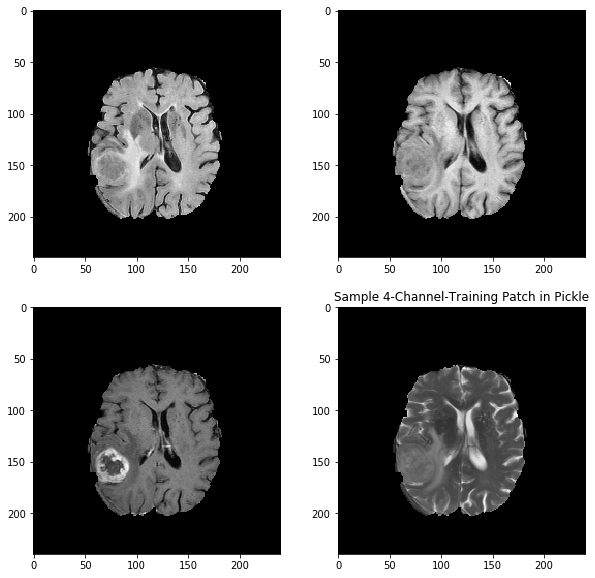

In [47]:
# Load an image from testing dataset
if os.path.exists('Pickles/test_imgs.pickle'):
    with open('Pickles/test_imgs.pickle','rb') as f:
        test_imgs = pickle.load(f)
    f.close()
else:
    print('Error! Test Images Pickle not found!')
    
img_num = 3
plt.figure(figsize = (10,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(test_imgs[img_num][i],cmap='gray')
plt.title("Sample 4-Channel-Training Patch in Pickle")

palt,numt=patchify(test_imgs[img_num],(33,33))
torch.cuda.empty_cache()
num_itr=int(float(numt)/100.0)
if not (numt%100)==0:
    num_itr+=1
patched=predict_img(net,palt[0:100],numt)
#for itr in range(num_itr)
#    patched = predict_img(net,palt[0:2000],numt)
#patched.extend(predict_img(net,palt[2000:],numt))
#mask=depatchify(patched,(240,240))

#print(mask.shape)

In [18]:
## Extract the car from the image using the predicted mask
#mask=np.expand_dims(mask, axis=2)
#img_seg = mask[3]*test_img
img_seg=np.zeros((mask.shape[1],mask.shape[2]))
for i in range(mask.shape[0]):
    img_seg += mask[i]#*i

### Plot original image and mask image

Text(0.5, 1.0, 'Tumor')

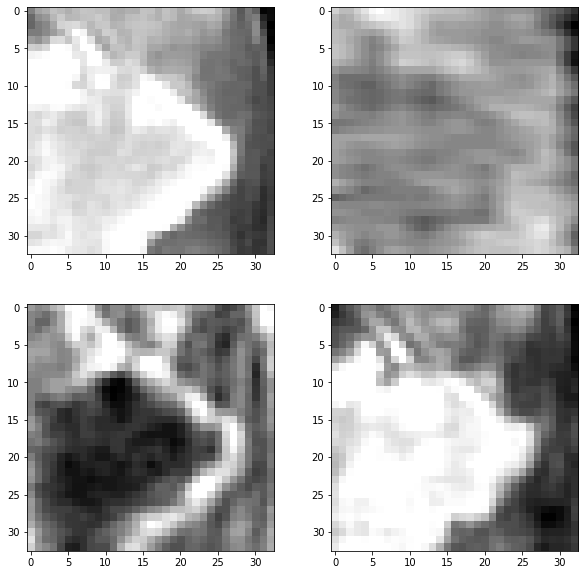

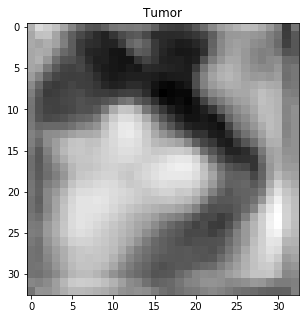

In [19]:
################################################ [TODO] ###################################################
# Plot original images and masks and segmented part
plt.figure(figsize = (10,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(test_img[i],cmap='gray')

plt.figure(figsize = (5,5))
plt.imshow(img_seg,cmap='gray')#vmax=img_seg.max())
plt.title('Tumor')

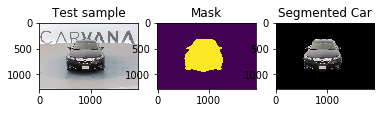

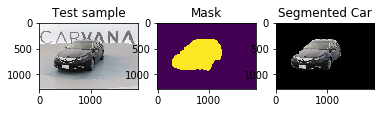

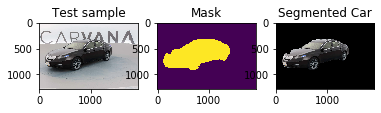

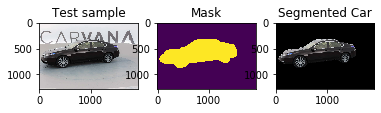

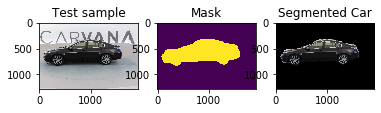

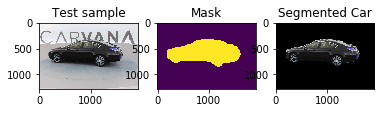

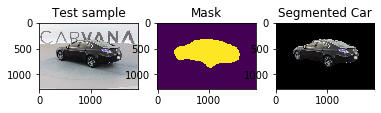

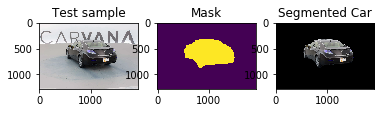

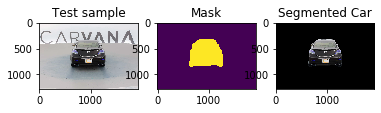

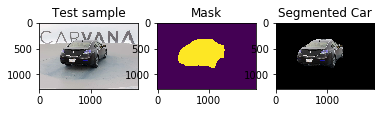

In [200]:
################################################ [TODO] ###################################################
test_img_paths =  glob.glob("data/test/*.jpg")
# Display ten more of test samples
for i in range(10):
    img=cv2.imread(test_img_paths[i])
    img_resize = cv2.resize(img, dsize=(100, 80), interpolation=cv2.INTER_CUBIC)
    mask = predict_img(net,img_resize.astype('float'))
    
    mask =  cv2.resize(mask, dsize=(img.shape[1],img.shape[0]))
    mask=np.expand_dims(mask, axis=2)
    seg_img = mask*img

    plt.subplot(1,3,1)
    plt.imshow(img)  #
    plt.title("Test sample")
    plt.subplot(1,3,2)
    plt.imshow(mask[:,:,0])  #
    plt.title("Mask")
    plt.subplot(1,3,3)
    plt.imshow(seg_img)  #
    plt.title("Segmented Car")
    plt.show()
    